In [3]:
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import os
import sys
import logging
mf_module_path = os.path.abspath(os.path.join('../python'))
if mf_module_path not in sys.path:
    sys.path.append(mf_module_path)
import mf
import mf_random
import hpoutil
import networkx
import obonet
import pickle

**Connect to MySQL database**

In [30]:
mydb = mysql.connector.connect(host='localhost',
                               user='mimicuser',
                               passwd='mimic',
                               database='mimiciiiv13',
                              auth_plugin='mysql_native_password')

First approach to query mysql from python

Check that MySQL connection works properly

In [31]:
df = pd.read_sql_query("SELECT * FROM LABEVENTS LIMIT 5;", mydb)
df

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,1,2,163353,51143,2138-07-17 20:48:00,0,0.0,%,None
1,2,2,163353,51144,2138-07-17 20:48:00,0,0.0,%,None
2,3,2,163353,51146,2138-07-17 20:48:00,0,0.0,%,None
3,4,2,163353,51200,2138-07-17 20:48:00,0,0.0,%,None
4,5,2,163353,51221,2138-07-17 20:48:00,0,0.0,%,abnormal


Get a cursor so that it can be used later

In [32]:
cursor = mydb.cursor(buffered=True)

We explored several method to compute the synergy score for different diseases. Method 1-3 all worked but the time and space requirements are too high. See the archived file. Here, we use method 4 to compute phenotype pairwise synergies.


## Algorithm

This method relies on the power of MySQL for doing queies and joins, return a batch of phenotype profiles a time, and then use the power of Numpy to do numeric computation.

Specificially, the method runs the following algorithm:

    1. For one diagnosis code, specify the phenotypes to analyze--a list of HPO terms.
    2. For a batch of patient*encounters, return a list of diagnosis codes (1 or 0)
    3. For the same batch of patient*encounters, return a list of phenotypes.
    4. Create a numpy array with dimension (N x P)
    5. Perform numeric computation with Numpy:
        outer product for ++ of PxP.T
        outer product for +- of Px(1-P).T
        outer product for -+ of (1-P)xP
        outer product for -- of (1-P)x(1-P).T
        combine the above with - and + of diagnosis value
        stack them together as a (N x P x P x 8) matrix.
        Step 1 - 5 are performed at each site. The resulting matrix is returned to JAX for final analyze.
    6. Compute pairwise synergy:
        use the multi-dimension array to calculate p(D = 1), p(D = 0), p(P1 * P2)
        compute mutual information of each phenotype in regarding to one diagnosis I(P:D)
        compute mutual information of two phenotypes in regarding to one diagnosis I(P:D)
        compute pairwise synergy
        

In [33]:
#TODO: rewrite to be backward compatible
def diagnosis_set():
    """Aggregate ICD9 codes with the first three digit and count how many times they appear. 
    Note this function uses encounters as the unit, meaning a code will counted twice if same patient was 
    diagnosed again at a later encounter."""
    diagnosis_count = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, \
        CASE \
        WHEN(ICD9_CODE LIKE 'V%') THEN SUBSTRING(ICD9_CODE, 1, 3) \
        WHEN(ICD9_CODE LIKE 'E%') THEN SUBSTRING(ICD9_CODE, 1, 4) \
        ELSE SUBSTRING(ICD9_CODE, 1, 3) END AS ICD9 \
        FROM DIAGNOSES_ICD", mydb)
    diagnosisSet = diagnosis_count.drop_duplicates().groupby('ICD9').size().sort_values(ascending=False)
    return diagnosisSet

#TODO: rewrite to be backward compatible
def createAbnormalPhenotypeTable(threshold, include_inferred=True, force_update=True):
    """
    This is the abnormal phenotypes. 
    @include_inferred whether to include inferred HPO. Default true.
    @force_update whether current table, if present, should be forced to update
    """
    if force_update:
        cursor.execute('''DROP TABLE IF EXISTS p''')
    if include_inferred:
        cursor.execute('''
                    CREATE TEMPORARY TABLE IF NOT EXISTS p
                    WITH abnorm AS (
                        SELECT
                            LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LabHpo.MAP_TO
                        FROM 
                            LABEVENTS 
                        JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
                        WHERE LabHpo.NEGATED = 'F'
                        
                        UNION ALL
                        
                        SELECT 
                            LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, INFERRED_LABHPO.INFERRED_TO AS MAP_TO 
                        FROM 
                            INFERRED_LABHPO 
                        JOIN 
                            LABEVENTS ON INFERRED_LABHPO.LABEVENT_ROW_ID = LABEVENTS.ROW_ID
                        )
                    SELECT SUBJECT_ID, HADM_ID, MAP_TO
                    FROM abnorm 
                    GROUP BY SUBJECT_ID, HADM_ID, MAP_TO
                    HAVING COUNT(*) > {}
                    -- parameter to control how to define an abnormal phenotype is present.
                '''.format(threshold))
    else:       
        cursor.execute('''
                    CREATE TEMPORARY TABLE IF NOT EXISTS p
                    WITH abnorm AS (
                        SELECT
                            LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LabHpo.MAP_TO
                        FROM 
                            LABEVENTS 
                        JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
                        WHERE LabHpo.NEGATED = 'F')
                    SELECT SUBJECT_ID, HADM_ID, MAP_TO
                    FROM abnorm 
                    GROUP BY SUBJECT_ID, HADM_ID, MAP_TO
                    HAVING COUNT(*) > {}
                    -- parameter to control how to define an abnormal phenotype is present.
                '''.format(threshold))
    cursor.execute('CREATE INDEX p_idx01 ON p (SUBJECT_ID, HADM_ID)')
    cursor.execute('CREATE INDEX p_idx02 ON p (MAP_TO);')


#TODO: rewrite to be backward compatible
def encountersWithDiagnosis(diagnosis):
    cursor.execute('''DROP TEMPORARY TABLE IF EXISTS d''')
    cursor.execute('''
        CREATE TEMPORARY TABLE IF NOT EXISTS d
        SELECT 
            DISTINCT SUBJECT_ID, HADM_ID, 1 AS DIAGNOSIS
        FROM 
            DIAGNOSES_ICD 
        WHERE ICD9_CODE LIKE '{}%'
        -- This is encounters with positive diagnosis
    '''.format(diagnosis))
    cursor.execute('CREATE INDEX d_idx01 ON d(SUBJECT_ID, HADM_ID)')

    
def createPhenotypeSet(diagnosis, threshold=1000):
    """
    Create the phenotypes that we should analyze. Exemely less frequently observed phenotypes are excluded.
    """
    cursor.execute('DROP TEMPORARY TABLE IF EXISTS ps')
    cursor.execute('''
            CREATE TEMPORARY TABLE ps
            WITH pd AS(
                SELECT p.*
                FROM 
                    p JOIN (SELECT 
                                DISTINCT SUBJECT_ID, HADM_ID, 1 AS DIAGNOSIS
                            FROM 
                                DIAGNOSES_ICD 
                            WHERE ICD9_CODE LIKE '{}%') AS d
                    ON p.SUBJECT_ID = d.SUBJECT_ID AND p.HADM_ID = d.HADM_ID)
            SELECT 
                MAP_TO, COUNT(*) AS N, 1 AS PHENOTYPE
            FROM pd
            GROUP BY MAP_TO
            HAVING N > {}
            ORDER BY N DESC'''.format(diagnosis, threshold))
    phenoSet = pd.read_sql_query('SELECT * FROM ps', mydb)
    return phenoSet


def batch_query(start_index, end_index):
    cursor.execute('''
                SELECT 
                    COUNT(DISTINCT SUBJECT_ID, HADM_ID) 
                FROM admissions 
                WHERE SUBJECT_ID BETWEEN {} AND {}
                '''.format(start_index, end_index))
    batch_size_actual = cursor.fetchall()[0][0]
    # create diagnosis table
    diagnosisList = pd.read_sql_query('''
                WITH a AS (
                    SELECT DISTINCT SUBJECT_ID, HADM_ID 
                    FROM admissions 
                    WHERE SUBJECT_ID BETWEEN {} AND {})
                SELECT 
                    a.SUBJECT_ID, a.HADM_ID, IF(d.DIAGNOSIS IS NULL, 0, 1) AS DIAGNOSIS
                FROM 
                    a
                LEFT JOIN
                    d ON a.SUBJECT_ID = d.SUBJECT_ID AND a.HADM_ID = d.HADM_ID         
                '''.format(start_index, end_index), mydb)
    # create phenotype profile table
    phenotyle_profile = pd.read_sql_query('''
        WITH 
            a AS (
                    SELECT 
                        DISTINCT SUBJECT_ID, HADM_ID 
                    FROM 
                        admissions 
                    WHERE SUBJECT_ID BETWEEN {} AND {}), 
            c as (
                SELECT a.*, ps.MAP_TO
                FROM a
                JOIN ps),
                -- cross product of all patient*encounter and phenotypes list
            pp as (
                SELECT p.*, 1 AS PHENOTYPE 
                FROM p RIGHT JOIN a 
                ON p.SUBJECT_ID = a.SUBJECT_ID AND p.HADM_ID = a.HADM_ID)

        SELECT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO, IF(pp.PHENOTYPE IS NULL, 0, 1) AS PHENOTYPE 
        FROM pp 
        RIGHT JOIN c ON pp.SUBJECT_ID = c.SUBJECT_ID and pp.HADM_ID = c.HADM_ID AND pp.MAP_TO = c.MAP_TO
        '''.format(start_index, end_index), mydb)
    return batch_size_actual, diagnosisList, phenotyle_profile

In [2]:
def iterate_in_batch(logger):
    logger.info('starting iterate_in_batch()')
    batch_size = 100
    # find the set of diagnosis that are worthy to analyze
    diagnosisSet = diagnosis_set()
    logger.info('diagnosis set completed')

    # create a temp table for abnormal phenotypes of each patient*encounter that met the threshold
    createAbnormalPhenotypeTable(threshold=1, force_update=True)
    logger.info('createAbnormalPhenotypeTable() completed')
    
    synergies = {}
    
    for diagnosis in diagnosisSet.keys():
        if (diagnosisSet[diagnosis] > 10000):
            # create a temp table for diagnosis of all patient*encouter to analyze
            encountersWithDiagnosis(diagnosis)
            logger.info('encountersWithDiagnosis() completed')

            ## create a list of phenotypes that we want to analyze for the specified disease and preset threshold
            phenoSet = createPhenotypeSet(diagnosis, threshold=100)
            logger.info('phenoSet completed')
            P_SIZE = len(phenoSet)

            ## find the start and end ROW_ID for patient*encounter
            cursor.execute('SELECT MIN(ROW_ID) AS min, MAX(ROW_ID) AS max FROM admissions')
            ADM_ID_START, ADM_ID_END = cursor.fetchall()[0]
            batch_N = ADM_ID_END - ADM_ID_START + 1
            TOTAL_BATCH = math.ceil(batch_N / batch_size) # total number of batches
            synergies[diagnosis] = mf.Synergy(diagnosis, phenoSet.MAP_TO)
            logger.info('starting batch queries for {}'.format(diagnosis))
            for i in np.arange(TOTAL_BATCH):
                start_index = i * batch_size + ADM_ID_START
                if i < TOTAL_BATCH - 1:
                    end_index = start_index + batch_size - 1
                else:
                    end_index = batch_N
                
                batch_size_actual, diagnosisList, phenotyle_profile = batch_query(start_index, end_index)
                
                if batch_size_actual > 0 :
                    diagnosisVector = diagnosisList.DIAGNOSIS
                    phenotypeProfileMatrix = phenotyle_profile.PHENOTYPE.values.reshape([batch_size_actual, P_SIZE])
                    if i % 10000 == 0:
                        logger.info('new batch: start_index={}, end_index={}, batch_size= {}, phenotype_size = {}'.format(start_index, end_index, batch_size_actual, len(phenoSet)))
                    synergies[diagnosis].add_batch(phenotypeProfileMatrix, diagnosisVector)
    
    return synergies

This method takes only 2 minutes to run.

In [ ]:
logger = logging.getLogger()
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',level=logging.DEBUG, stream=sys.stdout)

start = datetime.datetime.now()

synergies = iterate_in_batch(logger)
   
end = datetime.datetime.now()


In [32]:
print('running time: {}s'.format((end - start).total_seconds()))

running time: 910.764335s


In [ ]:
with open('synergies.obj', 'wb') as synergies_file:
    pickle.dump(synergies, synergies_file)

In [4]:
with open('synergies.obj', 'rb') as synergies_file:
    deserialized = pickle.load(synergies_file)

Plot the synergy scores. They are all pretty small.

In [5]:
len(deserialized)

10

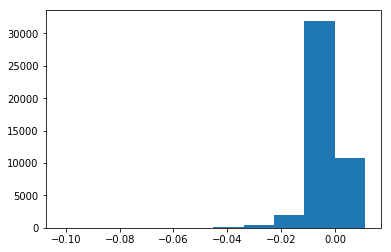

In [6]:
heart_failure = deserialized['428']
plt.hist(heart_failure.pairwise_synergy().flat, bins=10)
plt.show()

In [7]:
# load p values estimated from empirical distributions
path = '/Users/zhangx/git/MIMIC_HPO/src/main/resources/p_value_map_428.obj'
with open(path, 'rb') as f:
    p_value_map = pickle.load(f)
p_heart_failure = p_value_map['428']

In [8]:
data = heart_failure.pairwise_synergy_labeled_with_p_values(p_heart_failure)
data.reset_index(drop=True).head()

/Users/zhangx/anaconda3/lib/python3.6/site-packages/pandas/core/dtypes/dtypes.py:150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


,P1,P2,synergy,p
0,HP:0025546,HP:0025548,0.011284,0.0
1,HP:0025548,HP:0025546,0.011284,0.0
2,HP:0012379,HP:0002904,0.009951,0.0
3,HP:0002904,HP:0012379,0.009951,0.0
4,HP:0003573,HP:0012379,0.009292,0.0


remove phenotype pairs of which one is the ancestor or descendent of the other

In [9]:
hpo = hpoutil.HPO('/Users/zhangx/git/human-phenotype-ontology/hp.obo')
mask = np.array([hpo.has_dependency(data.P1[i], data.P2[i]) for i in np.arange(data.shape[0])])
S_heart_failure = data.loc[np.logical_not(mask), :].sort_values(by = 'synergy', ascending=False)

remove duplication record: (HP1, HP2) is the same to (HP2, HP1)

In [13]:
S_heart_failure = S_heart_failure.loc[S_heart_failure.P1 < S_heart_failure.P2, :]

In [14]:
top5percent = S_heart_failure.shape[0] * 0.05

top5percent_synergy_pair_heart_failure = S_heart_failure.reset_index(drop=True).iloc[0:int(top5percent), :]

In [16]:
top5percent_synergy_pair_heart_failure['P1_label'] = np.array([hpo.term_id2name_map().get(termid) for termid in top5percent_synergy_pair_heart_failure.P1])
top5percent_synergy_pair_heart_failure['P2_label'] = np.array([hpo.term_id2name_map().get(termid) for termid in top5percent_synergy_pair_heart_failure.P2])

In [17]:
top5percent_synergy_pair_heart_failure.head(20)

,P1,P2,synergy,p,P1_label,P2_label
0,HP:0002904,HP:0012379,0.009951,0.0,Hyperbilirubinemia,Abnormal enzyme/coenzyme activity
1,HP:0003573,HP:0012379,0.009292,0.0,Increased total bilirubin,Abnormal enzyme/coenzyme activity
2,HP:0004364,HP:0031969,0.007833,0.0,Abnormal circulating nitrogen compound concent...,Reduced blood urea nitrogen
3,HP:0001392,HP:0002904,0.007525,0.0,Abnormality of the liver,Hyperbilirubinemia
4,HP:0002012,HP:0002904,0.007525,0.0,Abnormality of the abdominal organs,Hyperbilirubinemia
5,HP:0002904,HP:0025031,0.007525,0.0,Hyperbilirubinemia,Abnormality of the digestive system
6,HP:0002904,HP:0002910,0.007525,0.0,Hyperbilirubinemia,Elevated hepatic transaminase
7,HP:0002904,HP:0410042,0.007525,0.0,Hyperbilirubinemia,Abnormal liver morphology
8,HP:0020058,HP:0025548,0.007221,0.0,Abnormal red blood cell count,Increased mean corpuscular hemoglobin concentr...
9,HP:0003573,HP:0025031,0.007209,0.0,Increased total bilirubin,Abnormality of the digestive system


In [ ]:
top5percent_synergy_pair_heart_failure.to_csv('top5percent_synergy_pair_heart_failure.csv', index=False)

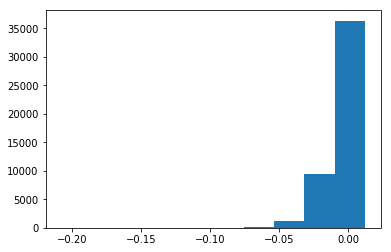

In [18]:
acute_renal_failure = deserialized['584']
plt.hist(acute_renal_failure.pairwise_synergy().flat, bins=10)
plt.show()

In [21]:
# load p values estimated from empirical distributions
path = '/Users/zhangx/git/MIMIC_HPO/src/main/resources/p_value_map_584.obj'
with open(path, 'rb') as f:
    p_value_map = pickle.load(f)
p_renal_failure = p_value_map['584']
data = acute_renal_failure.pairwise_synergy_labeled_with_p_values(p_renal_failure)
data.reset_index(drop=True).head()

/Users/zhangx/anaconda3/lib/python3.6/site-packages/pandas/core/dtypes/dtypes.py:150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


,P1,P2,synergy,p
0,HP:0002904,HP:0011014,0.012154,0.0
1,HP:0002904,HP:0011015,0.012154,0.0
2,HP:0011014,HP:0002904,0.012154,0.0
3,HP:0011015,HP:0002904,0.012154,0.0
4,HP:0001928,HP:0002904,0.011185,0.0


In [24]:
mask = np.array([hpo.has_dependency(data.P1[i], data.P2[i]) for i in np.arange(data.shape[0])])
S_acute_renal_failure = data.loc[np.logical_not(mask), :].sort_values(by = 'synergy', ascending=False)
S_acute_renal_failure = S_acute_renal_failure.loc[S_acute_renal_failure.P1 < S_acute_renal_failure.P2, :]
top5percent = S_acute_renal_failure.shape[0] * 0.05
top5percent_synergy_pair_acute_renal_failure = S_acute_renal_failure.reset_index(drop=True).iloc[0:int(top5percent), :]
top5percent_synergy_pair_acute_renal_failure['P1_label'] = np.array([hpo.term_id2name_map().get(termid) for termid in top5percent_synergy_pair_acute_renal_failure.P1])
top5percent_synergy_pair_acute_renal_failure['P2_label'] = np.array([hpo.term_id2name_map().get(termid) for termid in top5percent_synergy_pair_acute_renal_failure.P2])

In [28]:
top5percent_synergy_pair_acute_renal_failure.head(20)

,P1,P2,synergy,p,P1_label,P2_label
0,HP:0002904,HP:0011014,0.012154,0.0,Hyperbilirubinemia,Abnormal glucose homeostasis
1,HP:0002904,HP:0011015,0.012154,0.0,Hyperbilirubinemia,Abnormal blood glucose concentration
2,HP:0001928,HP:0002904,0.011185,0.0,Abnormality of coagulation,Hyperbilirubinemia
3,HP:0003573,HP:0011014,0.010479,0.0,Increased total bilirubin,Abnormal glucose homeostasis
4,HP:0003573,HP:0011015,0.010479,0.0,Increased total bilirubin,Abnormal blood glucose concentration
5,HP:0002904,HP:0003074,0.009499,0.0,Hyperbilirubinemia,Hyperglycemia
6,HP:0001928,HP:0003573,0.008893,0.0,Abnormality of coagulation,Increased total bilirubin
7,HP:0002904,HP:0010927,0.008887,0.0,Hyperbilirubinemia,Abnormal blood inorganic cation concentration
8,HP:0002904,HP:0004363,0.008813,0.0,Hyperbilirubinemia,Abnormal circulating calcium concentration
9,HP:0002901,HP:0002904,0.008680,0.0,Hypocalcemia,Hyperbilirubinemia


In [29]:
top5percent_synergy_pair_acute_renal_failure.to_csv('top5percent_synergy_pair_acute_renal_failure.csv', index=False)

In [ ]:
primary_diagnosis_count = pd.read_sql_query('''SELECT 
                        ICD9_CODE, COUNT(*) AS N 
                    FROM 
                        DIAGNOSES_ICD 
                    WHERE 
                        SEQ_NUM = 1 
                    GROUP BY 
                        ICD9_CODE 
                    HAVING 
                        N > 100 
                    ORDER BY 
                        N DESC ;
''', mydb)
primary_diagnosis_count.to_csv('primary_diagnosis_count.csv', index = False)

In [34]:
diagnosis_set = diagnosis_set()

In [35]:
diagnosis_set

ICD9
401     21305
427     17226
276     15101
272     14558
414     14410
250     14222
428     13608
518     13346
285     12606
584     11422
V45      9132
530      7392
599      7329
V58      7162
585      6918
403      6438
V10      6410
V30      6340
038      6265
V05      5790
V29      5735
995      5642
424      5488
780      5449
410      5430
785      5351
244      5237
305      5213
997      5158
998      5055
        ...  
116         1
E857        1
E856        1
E873        1
E840        1
E835        1
E827        1
134         1
316         1
E908        1
E801        1
E800        1
E921        1
E923        1
E925        1
219         1
E926        1
E962        1
090         1
E963        1
085         1
E964        1
083         1
937         1
915         1
E977        1
E982        1
066         1
062         1
V91         1
Length: 1070, dtype: int64

In [52]:
cursor.close()
mydb.close()